## Function to solve the subsistence problem



The following code block defines a function
`solve_subsistence_problem`, which takes as arguments a dataframe
mapping different foods to nutrients; a series of prices for those
same foods; a series giving dietary recommended intake (DRI) minimums;
and a series giving dietary recommended maximums.



In [35]:
from  scipy.optimize import linprog as lp
import numpy as np
import warnings

def solve_subsistence_problem(FoodNutrients,Prices,dietmin,dietmax,max_weight=None,tol=1e-6):
    """Solve Stigler's Subsistence Cost Problem.

    Inputs:
       - FoodNutrients : A pd.DataFrame with rows corresponding to foods, columns to nutrients.
       - Prices : A pd.Series of prices for different foods
       - diet_min : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing minimum intakes.
       - diet_max : A pd.Series of DRIs, with index corresponding to columns of FoodNutrients,
                    describing maximum intakes.
       - max_weight : Maximum weight (in hectograms) allowed for diet.
       - tol : Solution values smaller than this in absolute value treated as zeros.
       
    """
    try: 
        p = Prices.apply(lambda x:x.magnitude)
    except AttributeError:  # Maybe not passing in prices with units?
        warnings.warn("Prices have no units.  BE CAREFUL!  We're assuming prices are per hectogram or deciliter!")
        p = Prices

    p = p.dropna()

    # Compile list that we have both prices and nutritional info for; drop if either missing
    use = p.index.intersection(FoodNutrients.columns)
    p = p[use]

    # Drop nutritional information for foods we don't know the price of,
    # and replace missing nutrients with zeros.
    Aall = FoodNutrients[p.index].fillna(0)

    # Drop rows of A that we don't have constraints for.
    Amin = Aall.loc[Aall.index.intersection(dietmin.index)]
    Amin = Amin.reindex(dietmin.index,axis=0)
    idx = Amin.index.to_frame()
    idx['type'] = 'min'
    #Amin.index = pd.MultiIndex.from_frame(idx)
    #dietmin.index = Amin.index
    
    Amax = Aall.loc[Aall.index.intersection(dietmax.index)]
    Amax = Amax.reindex(dietmax.index,axis=0)
    idx = Amax.index.to_frame()
    idx['type'] = 'max'
    #Amax.index = pd.MultiIndex.from_frame(idx)
    #dietmax.index = Amax.index

    # Minimum requirements involve multiplying constraint by -1 to make <=.
    A = pd.concat([Amin,
                   -Amax])

    b = pd.concat([dietmin,
                   -dietmax]) # Note sign change for max constraints

    # Make sure order of p, A, b are consistent
    A = A.reindex(p.index,axis=1)
    A = A.reindex(b.index,axis=0)

    if max_weight is not None:
        # Add up weights of foods consumed
        A.loc['Hectograms'] = -1
        b.loc['Hectograms'] = -max_weight
        
    # Now solve problem!  (Note that the linear program solver we'll use assumes
    # "less-than-or-equal" constraints.  We can switch back and forth by
    # multiplying $A$ and $b$ by $-1$.)

    result = lp(p, -A, -b, method='interior-point')

    result.A = A
    result.b = b
    
    if result.success:
        result.diet = pd.Series(result.x,index=p.index)
    else: # No feasible solution?
        warnings.warn(result.message)
        result.diet = pd.Series(result.x,index=p.index)*np.nan  

    return result

## Setup



In [36]:
#!git reset --hard origin/master  # To revert to original
!pip install -r requirements.txt --upgrade

## USDA Food Central DataBase

API key to access USDA Food Central DataBase


In [37]:
# API key for Gov; substitute your own!
apikey = "zjPzq6seNovgsh28xoUlw7NW7Ikj7Zidg1We4Ekv"

## Data on Prices of Different Foods


We have a spreadsheet for the prices in each supermarket (Trader Joes, Walmart, Wholefoods, Target, and FoodMaxx) . We will be using the read_sheets function to import the data on prices into this notebook. You can find the spreadsheet here: (https://docs.google.com/spreadsheets/d/1dZW1_vvjZwcAfxfHiAkjqrLEpFbFsZ4s7_MzTG6Ezu0/edit#gid=1105367422)

Below we will show dataframes for each of the 5 supermarkets we obtained grocery prices from.

## Trader Joes Price List


In [139]:
import pandas as pd
from eep153_tools.sheets import read_sheets

df = read_sheets('https://docs.google.com/spreadsheets/d/1dZW1_vvjZwcAfxfHiAkjqrLEpFbFsZ4s7_MzTG6Ezu0/edit#gid=0',sheet='Trader Joes')
df

Key available for students@eep153.iam.gserviceaccount.com.


,Food,Quantity,Units,Price,Date,Location,FDC
0,"Banana,raw",120.00,grams,0.19,02/27/23,Trader Joe's,1105314
1,"Apple, Gala",0.33,pound,1.29,02/27/23,Trader Joe's,1750341
2,"Oranges, Navel",3.00,pound,3.69,02/27/23,Trader Joe's,746771
3,Blueberries,11.00,oz,4.49,03/01/23,Trader Joe's,2346411
4,Raspberries,6.00,oz,3.99,03/01/23,Trader Joe's,2346410
5,"Grapes, green, seedless",2.00,pound,5.99,03/01/23,Trader Joe's,2346413
6,Strawberries,1.00,pound,3.99,02/27/23,Trader Joe's,167762
7,"Lentils, red",17.63,oz,3.29,02/27/23,Trader Joe's,174284
8,Tofu,19.00,oz,2.29,03/01/23,Trader Joe's,173788
9,"Split peas, dry",12.00,oz,2.69,03/01/23,Trader Joe's,172428


## Walmart Price List


In [140]:
import pandas as pd
from eep153_tools.sheets import read_sheets

walmartdf = read_sheets('https://docs.google.com/spreadsheets/d/1dZW1_vvjZwcAfxfHiAkjqrLEpFbFsZ4s7_MzTG6Ezu0/edit#gid=0',sheet='Walmart')
walmartdf

Key available for students@eep153.iam.gserviceaccount.com.


,Food,Quantity,Units,Price,Date,Location,FDC,Note
0,"Banana,raw",1.0,lbs,0.77,02/27/23,walmart,1105073,
1,"Apple, Gala",1.0,lbs,1.67,02/27/23,walmart,1750341,
2,"Oranges, Navel",1.0,lbs,0.88,02/27/23,walmart,746771,
3,Blueberries,11.0,oz,3.38,02/27/23,walmart,2346411,
4,Raspberries,12.0,oz,5.98,02/27/23,walmart,2346410,
5,"Grapes, green, seedless",1.0,lbs,1.98,02/27/23,walmart,2346413,
6,Strawberries,1.0,lbs,2.78,02/27/23,walmart,167762,
7,"Lentils, red",27.0,oz,9.55,03/01/23,walmart,174284,
8,Tofu,1.0,lbs,2.12,02/27/23,walmart,173788,
9,"Split peas, dry",1.0,lbs,1.48,02/27/23,walmart,172428,green


## Whole Foods Price List


In [141]:
import pandas as pd
from eep153_tools.sheets import read_sheets

wholefoodsdf = read_sheets('https://docs.google.com/spreadsheets/d/1dZW1_vvjZwcAfxfHiAkjqrLEpFbFsZ4s7_MzTG6Ezu0/edit#gid=0',sheet='Whole Foods')
wholefoodsdf

Key available for students@eep153.iam.gserviceaccount.com.


,Food,FDC,Quantity,Units,Price,Date,Location,Notes
0,"Banana,raw",1105314,1.0,lbs,0.99,2/27/23,Whole Foods,
1,"Apple, Gala",1750341,3.0,lbs,6.49,2/27/23,Whole Foods,
2,"Oranges, Navel",746771,1.0,lbs,2.39,2/27/23,Whole Foods,
3,Blueberries,2346411,11.0,oz,6.99,2/27/23,Whole Foods,
4,Raspberries,2346410,12.0,oz,8.69,2/27/23,Whole Foods,Only organic
5,"Grapes, green, seedless",2346413,3.0,lbs,7.49,2/27/23,Whole Foods,
6,Strawberries,167762,1.0,lbs,4.49,2/27/23,Whole Foods,
7,"Lentils, red",174284,1.0,lbs,2.99,2/27/23,Whole Foods,
8,Tofu,173788,14.0,oz,2.99,2/27/23,Whole Foods,
9,"Split peas, dry",172428,1.0,lbs,2.99,2/27/23,Whole Foods,


## FoodMaxx Price List


In [142]:
import pandas as pd
from eep153_tools.sheets import read_sheets

foodmaxxdf = read_sheets('https://docs.google.com/spreadsheets/d/1dZW1_vvjZwcAfxfHiAkjqrLEpFbFsZ4s7_MzTG6Ezu0/edit#gid=0',sheet='Food Max')
foodmaxxdf

Key available for students@eep153.iam.gserviceaccount.com.


,Food,Quantity,Units,Price,Date,Location,FDC
0,"Banana,raw",1,lbs,0.69,02/27/23,FoodMaxx,1105073
1,"Apple, Gala",1,lbs,0.99,02/27/23,FoodMaxx,1750341
2,"Oranges, Navel",1,lbs,0.99,02/27/23,FoodMaxx,746771
3,Blueberries,6,oz,3.49,02/27/23,FoodMaxx,2346411
4,Raspberries,1,lbs,4.99,02/27/23,FoodMaxx,2346410
5,"Grapes, green, seedless",1,lbs,2.99,02/27/23,FoodMaxx,2346413
6,Strawberries,1,lbs,6.99,02/27/23,FoodMaxx,167762
7,"Lentils, red",1,lbs,1.99,02/27/23,FoodMaxx,174284
8,Tofu,14,oz,2.99,02/27/23,FoodMaxx,173788
9,"Split peas, dry",1,lbs,1.79,02/27/23,FoodMaxx,172428


## Target Price List


In [143]:
import pandas as pd
from eep153_tools.sheets import read_sheets

targetdf = read_sheets('https://docs.google.com/spreadsheets/d/1dZW1_vvjZwcAfxfHiAkjqrLEpFbFsZ4s7_MzTG6Ezu0/edit#gid=0',sheet='Target')
targetdf

Key available for students@eep153.iam.gserviceaccount.com.


,Food,Quantity,Units,Price,Date,Location,FDC,notes
0,"Banana,raw",2.00,lbs,1.99,02/27/23,Target,1105314,organic
1,"Apple, Gala",0.66,lbs,5.99,02/27/23,Target,1750341,organic
2,"Oranges, Navel",4.00,lbs,5.99,02/27/23,Target,746771,
3,Blueberries,11.20,oz,3.59,02/27/23,Target,2346411,
4,Raspberries,12.00,oz,8.29,02/27/23,Target,2346410,
5,"Grapes, green, seedless",1.50,lb,4.29,02/27/23,Target,2346413,
6,Strawberries,1.00,lb,3.49,02/27/23,Target,167762,
7,"Lentils, red",1.00,lb,1.59,02/27/23,Target,174284,green
8,Tofu,14.00,oz,3.29,02/27/23,Target,173788,
9,"Split peas, dry",1.00,lb,1.39,02/27/23,Target,172428,


### Look up nutritional information for foods



Now we have a list of foods with prices.  Do lookups on USDA database
to get nutritional information.



In [145]:
import fooddatacentral as fdc
import warnings

D = {}
count = 0
for food in  df.Food.tolist():
    try:
        FDC = df.loc[df.Food==food,:].FDC[count]
        count+=1
        D[food] = fdc.nutrients(apikey,FDC).Quantity
    except AttributeError: 
        warnings.warn("Couldn't find FDC Code %s for food %s." % (food,FDC))        

FoodNutrients = pd.DataFrame(D,dtype=float)
FoodNutrients = FoodNutrients.fillna(0)
FoodNutrients

,"Banana,raw","Apple, Gala","Oranges, Navel",Blueberries,Raspberries,"Grapes, green, seedless",Strawberries,"Lentils, red",Tofu,"Split peas, dry",...,"Lettuce, Romaine",Mushrooms,Spinach,"Rice, White","Tortillas, corn","Oats, rolled","Soy milk, unsweetened","Peanut butter, creamy","Rice, Brown","Spaghetti, dry"
"Ergosta-5,7-dienol",0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.000,5.841,0.0,0.000,0.000,0.0,0.0000,0.00,0.000,0.000
"Ergosta-7,22-dienol",0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.000,1.543,0.0,0.000,0.000,0.0,0.0000,0.00,0.000,0.000
Alanine,0.0,0.0,0.028,0.0,0.0,0.0,0.033,1.042,0.0,1.049,...,0.056,0.000,0.0,0.377,0.215,0.0,0.1394,1.16,0.437,0.438
"Alcohol, ethyl",0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.0000,0.00,0.000,0.000
Amino acids,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.0000,0.00,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cis-Lutein/Zeaxanthin,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.9655,0.00,0.000,0.000
cis-Lycopene,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.0000,0.00,0.000,0.000
cis-beta-Carotene,1.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.0000,0.00,0.000,0.000
trans-Lycopene,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.000,...,0.000,0.000,0.0,0.000,0.000,0.0,0.0000,0.00,0.000,0.000


## Units & Prices



Now, the prices we observe can be for lots of different quantities and
units.  The FDC database basically wants everything in either hundreds
of grams (hectograms) or hundreds of milliliters (deciliters).  
We use the `units` function to convert all foods to either
deciliters or hectograms, to match FDC database:



In [146]:
# Convert food quantities to FDC units
df['FDC Quantity'] = df[['Quantity','Units']].T.apply(lambda x : fdc.units(x['Quantity'],x['Units']))

# Now may want to filter df by time or place--need to get a unique set of food names.
df['FDC Price'] = df['Price']/df['FDC Quantity']

df.dropna(how='any') # Drop food with any missing data

# To use minimum price observed
Prices = df.groupby('Food',sort=False)['FDC Price'].min()
Prices

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



Food
 Banana,raw                0.15833333333333335 / hectogram
Apple, Gala                 0.8618070249045213 / hectogram
Oranges, Navel              0.2711685824873994 / hectogram
Blueberries                 1.4398189923056004 / hectogram
Raspberries                 2.3457184696470974 / hectogram
Grapes, green, seedless     0.6602844752437083 / hectogram
Strawberries                0.8796444261176615 / hectogram
Lentils, red                0.6582605491441835 / hectogram
Tofu                        0.4251440677081007 / hectogram
Split peas, dry             0.7907246470364275 / hectogram
Chickpeas, canned             0.71047757368082 / hectogram
Quinoa, dry                 0.8796444261176615 / hectogram
Hummus                      0.8796444261176615 / hectogram
Black beans, canned        0.24805560338737195 / hectogram
Tomato, Roma                 0.659182163932784 / hectogram
Broccoli                    0.7319347104537935 / hectogram
Kale                        1.0546914622924541 / he

## Dietary Requirements



Next, we will create a function that takes as arguments the characteristics of a person (e.g., age, sex, activity level) and returns a pandas.Series of Dietary Reference Intakes (DRI's) or "Recommended Daily Allowances" (RDA) of a variety of nutrients appropriate for our population of interest.

Our data for this is based
on  US government recommendations available at
[https://www.dietaryguidelines.gov/sites/default/files/2021-03/Dietary_Guidelines_for_Americans-2020-2025.pdf](https://www.dietaryguidelines.gov/sites/default/files/2021-03/Dietary_Guidelines_for_Americans-2020-2025.pdf)

These data have been put into a google sheets that we will access using the read_sheets function defined earlier. You can access the spreadsheet here: https://docs.google.com/spreadsheets/d/1swR8k5x6GaRZd5DvfDF55oeAZZvOC4edB3ofOKov8nE/edit#gid=188168169


Note that we&rsquo;ve tweaked the nutrient labels to match those in the FDC
data.

Also note that the last two rows refer to the maximum requirements which involve multiplying the constraint by -1 to make <=.


In [147]:
RDIs = read_sheets('https://docs.google.com/spreadsheets/d/1swR8k5x6GaRZd5DvfDF55oeAZZvOC4edB3ofOKov8nE/edit#gid=188168169')
def recommended_diet(age, sex, activity_level):
    if activity_level == 'high' or activity_level == 'High':
        if sex == 'Female' or sex == 'F':
            if age in range(1,4):
                agerange = '1-3'
            if age in range(4,9):
                agerange = '4-8'
            if age in range(9,14):
                agerange = '9-13'
            if age in range(14,19):
                agerange = '14-18'
            if age in range(19,31):
                agerange = '19-30'
            if age in range(31,51):
                agerange = '31-50'
            if age in range(51,100000000):
                agerange = '51+'
            group = 'F ' + agerange
        if sex == 'Male' or sex == 'M':
            if age in range(1,4):
                agerange = '1-3'
            if age in range(4,9):
                agerange = '4-8'
            if age in range(9,14):
                agerange = '9-13'
            if age in range(14,19):
                agerange = '14-18'
            if age in range(19,31):
                agerange = '19-30'
            if age in range(31,51):
                agerange = '31-50'
            if age in range(51,100000000):
                agerange = '51+'
            group = 'M ' + agerange
        bmin = RDIs['high_activity'].set_index('Nutrition')[[group]]
        bmax = RDIs['high_max'].set_index('Nutrition')[[group]]
    if activity_level == 'moderate' or activity_level == 'Moderate':
        if sex == 'Female' or sex == 'F':
            if age in range(1,4):
                agerange = '1-3'
            if age in range(4,9):
                agerange = '4-8'
            if age in range(9,14):
                agerange = '9-13'
            if age in range(14,19):
                agerange = '14-18'
            if age in range(19,31):
                agerange = '19-30'
            if age in range(31,51):
                agerange = '31-50'
            if age in range(51,100000000):
                agerange = '51+'
            group = 'F ' + agerange
        if sex == 'Male' or sex == 'M':
            if age in range(14,19):
                agerange = '14-18'
            if age in range(19,31):
                agerange = '19-30'
            if age in range(31,51):
                agerange = '31-50'
            if age in range(51,100000000):
                agerange = '51+'
            group = 'M ' + agerange
        bmin = RDIs['moderate_activity'].set_index('Nutrition')[[group]]
        bmax = RDIs['moderate_max'].set_index('Nutrition')[[group]]
    b = pd.concat([bmin,-bmax])
    return b

Key available for students@eep153.iam.gserviceaccount.com.


Let's find our the recommended daily allowance of nutrient intake for a Male aged 52 years old with high activity levels. 

In [148]:
recommended = recommended_diet(50, 'M' , 'High')

# Define *minimums*
diet_min = recommended[:20]

# Define *maximums*
diet_max = recommended[20:]

recommended


,M 31-50
Nutrition,
Energy,2850.0
Protein,56.0
"Fiber, total dietary",30.8
"Folate, DFE",400.0
"Calcium, Ca",1000.0
"Carbohydrate, by difference",130.0
"Iron, Fe",8.0
"Magnesium, Mg",420.0
Niacin,16.0


For this code demonstration, we will use nutritional information based on high activity levels.

In [149]:
from eep153_tools.sheets import read_sheets

DRI_url = "https://docs.google.com/spreadsheets/d/1swR8k5x6GaRZd5DvfDF55oeAZZvOC4edB3ofOKov8nE/edit#gid=188168169"

DRIs = read_sheets(DRI_url)

# Define *minimums*
diet_min = DRIs['moderate_activity'].set_index('Nutrition')

# Define *maximums*
diet_max = DRIs['moderate_max'].set_index('Nutrition')


Key available for students@eep153.iam.gserviceaccount.com.


## Using `solve_subsistence_problem` to analyze diet



Let&rsquo;s choose a particular group (type of person with particular
dietary requirements) and solve the subsistence problem for them:



In [150]:
group = 'F 19-30'
tol = 1e-6

result = solve_subsistence_problem(FoodNutrients,Prices,diet_min[group],diet_max[group],tol=tol)

print("Cost of diet for %s is $%4.2f per day.\n" % (group,result.fun))

# Put back into nice series
diet = result.diet

print("\nDiet (in 100s of grams or milliliters):")
print(diet[diet >= tol])  # Drop items with quantities less than precision of calculation.
print()

tab = pd.DataFrame({"Outcome":np.abs(result.A).dot(diet),"Recommendation":np.abs(result.b)})
print("\nWith the following nutritional outcomes of interest:")
print(tab)
print()

print("\nConstraining nutrients are:")
excess = tab.diff(axis=1).iloc[:,1]
print(excess.loc[np.abs(excess) < tol*100].index.tolist())

Cost of diet for F 19-30 is $4.69 per day.


Diet (in 100s of grams or milliliters):
 Banana,raw              1.589644
Oranges, Navel           0.338834
Black beans, canned      5.381961
Kale                     0.168344
Carrot                   0.359735
Avocado                  0.304517
Tortillas, corn          0.158310
Soy milk, unsweetened    6.105317
Peanut butter, creamy    1.773057
dtype: float64


With the following nutritional outcomes of interest:
                                    Outcome  Recommendation
Nutrition                                                  
Energy                          3229.221341          2100.0
Protein                          100.833751            46.0
Fiber, total dietary              55.844313            28.0
Folate, DFE                      400.000002           400.0
Calcium, Ca                     1000.000014          1000.0
Carbohydrate, by difference      192.369320           130.0
Iron, Fe                          18.000000            18.0

## Effects of Price Changes on Subsistence Diet Cost



As prices change, we should expect the minimum cost diet to also
  change.  The code below creates a graph which changes prices away
  from the \`base&rsquo; case one food at a time, and plots changes in total
  diet cost.



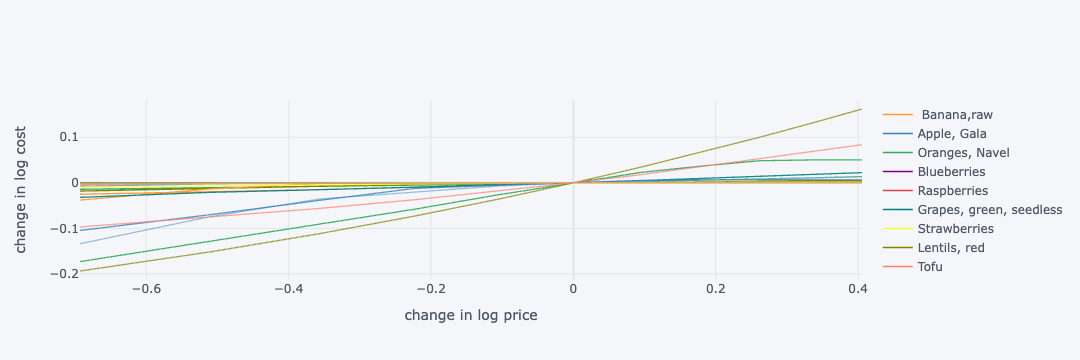

In [102]:
import cufflinks as cf
cf.go_offline()

scale = [.5,.6,.7,.8,.9,1.,1.1,1.2,1.3,1.4,1.5]

cost0 = solve_subsistence_problem(FoodNutrients,Prices,diet_min[group],diet_max[group],tol=tol).fun

Price_response={}
for s in scale:
    cost = {}
    for i,p in enumerate(Prices):
        my_p = Prices.copy()
        my_p[i] = p*s
        result = solve_subsistence_problem(FoodNutrients,my_p,diet_min[group],diet_max[group],tol=tol)
        cost[Prices.index[i]] = np.log(result.fun/cost0)
    Price_response[np.log(s)] = cost

Price_response = pd.DataFrame(Price_response).T
Price_response.iplot(xTitle='change in log price',yTitle='change in log cost')

## Effects of Price Changes on Subsistence Diet Composition



The code below creates a graph which changes prices just for *one* food,
  and traces out the effects of this change on all the foods consumed.



/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



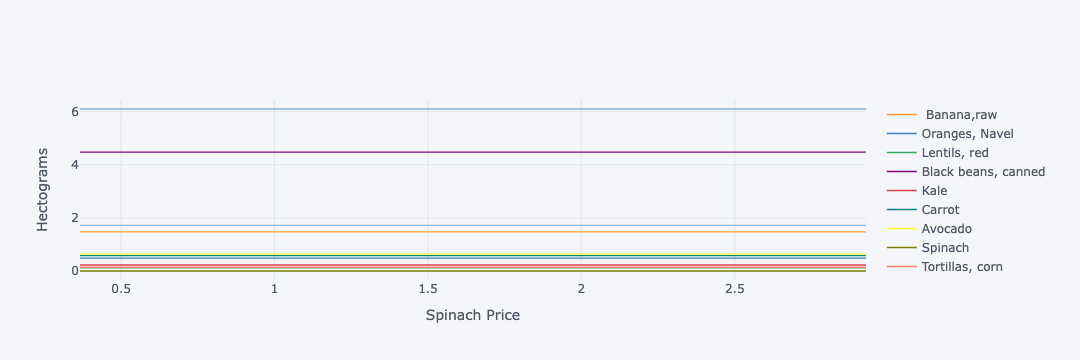

In [103]:
import cufflinks as cf
cf.go_offline()

ReferenceGood = 'Spinach'

scale = [0.5,0.75,0.9,1.,1.1,1.2,1.3,1.4,1.5,2,4]

cost0 = solve_subsistence_problem(FoodNutrients,Prices,diet_min[group],diet_max[group],tol=tol).fun

my_p = Prices.copy()

diet = {}
for s in scale:

    my_p[ReferenceGood] = Prices[ReferenceGood]*s
    result = solve_subsistence_problem(FoodNutrients,my_p,diet_min[group],diet_max[group],tol=tol)
    diet[my_p[ReferenceGood]] = result.diet

Diet_response = pd.DataFrame(diet).T
Diet_response.index.name = '%s Price' % ReferenceGood

Diet_response.reset_index(inplace=True)

# Get rid of units for index (cufflinks chokes)
Diet_response['%s Price' % ReferenceGood] = Diet_response['%s Price' % ReferenceGood].apply(lambda x: x.magnitude)

Diet_response = Diet_response.set_index('%s Price' % ReferenceGood)

# Just look at goods consumed in quantities greater than error tolerance
Diet_response.loc[:,(Diet_response>tol).sum()>0].iplot(xTitle='%s Price' % ReferenceGood,yTitle='Hectograms')

## Effects of Price Changes on Subsistence Diet Nutrition



The code below creates a graph which uses the food price changes
  described above, but maps into nutrients.



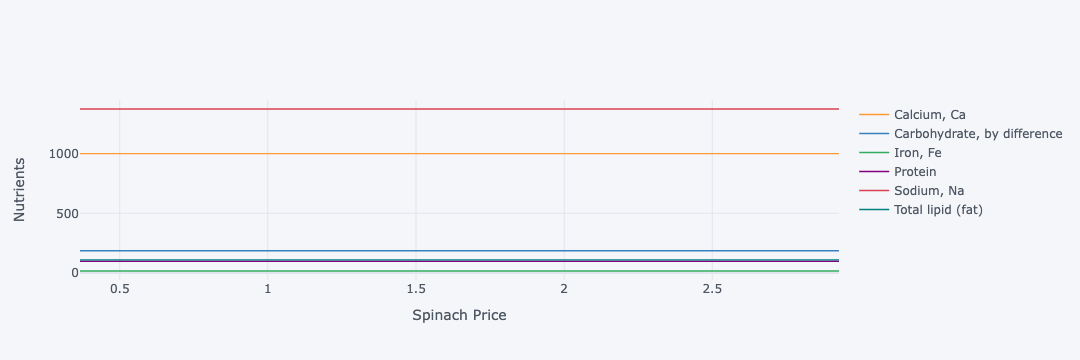

In [104]:
# Matrix product maps quantities of food into quantities of nutrients
NutrientResponse = Diet_response@FoodNutrients.T

# Drop columns of missing nutrients
NutrientResponse = NutrientResponse.loc[:,NutrientResponse.count()>0]
NutrientResponse.iplot(xTitle='%s Price' % ReferenceGood,yTitle='Nutrients')

## Adding Constraint on Total Weight



At least at some prices the minimum cost subistence diet involves
eating unreasonable amounts of food (e.g., 10 kilograms of cabbage per
day).  We can easily add an additional constraint of the form
$$
     \sum x_i \leq \text{max weight}
$$
to our linear programming problem since it&rsquo;s just another linear
inequality, and this may give us more realistic results.



### Price Changes and Subsistence Diet Composition with Weight Constraint



Re-do our analysis of changing prices, but with a constraint that
  total weight of diet must be less that 12 hectograms (1.2 kg).



In [105]:
import cufflinks as cf
cf.go_offline()

ReferenceGood = 'Spinach'

scale = [0.5,0.75,0.9,1.,1.1,1.2,1.3,1.4,1.5,2,4]

cost0 = solve_subsistence_problem(FoodNutrients,Prices,
                                  diet_min[group],diet_max[group],max_weight=12,tol=tol).fun

my_p = Prices.copy()

diet = {}
for s in scale:

    my_p[ReferenceGood] = Prices[ReferenceGood]*s
    result = solve_subsistence_problem(FoodNutrients,my_p,
                                       diet_min[group],diet_max[group],max_weight=12,tol=tol)
    diet[my_p[ReferenceGood]] = result.diet

Diet_response = pd.DataFrame(diet).T
Diet_response.index.name = '%s Price' % ReferenceGood

Diet_response.reset_index(inplace=True)

# Get rid of units for index (cufflinks chokes)
Diet_response['%s Price' % ReferenceGood] = Diet_response['%s Price' % ReferenceGood].apply(lambda x: x.magnitude)

Diet_response = Diet_response.set_index('%s Price' % ReferenceGood)

# Just look at goods consumed in quantities greater than error tolerance
Diet_response.loc[:,(Diet_response>tol).sum()>0].iplot(xTitle='%s Price' % ReferenceGood,yTitle='Hectograms')

/tmp/ipykernel_331/879501582.py:78: UserWarning:

The algorithm terminated successfully and determined that the problem is infeasible.



PlotlyEmptyDataError: Empty data list found. Make sure that you populated the list of data objects you're sending and try again.
Questions? Visit support.plot.ly